In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
import pickle
import pandas as pd

In [2]:
with open('./source/wiki_df.pickle', 'rb') as handle:
    dtf = pickle.load(handle)

In [3]:
dtf.shape

(1011, 7)

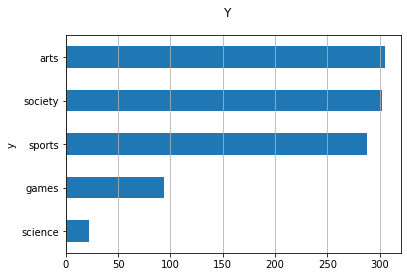

In [4]:
fig, ax = plt.subplots()
fig.suptitle("Y", fontsize=12)
dtf["y"].reset_index().groupby("y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [5]:
nlp = gensim_api.load("word2vec-google-news-300")

In [6]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [7]:
lst_stopwords = nltk.corpus.stopwords.words("english")

dtf["text_clean"] = dtf["X"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,pg_title,section_title,table_caption,columns,values,y,X,text_clean
0,Mid Antrim (Northern Ireland Parliament consti...,Members of Parliament,Members of Parliament,Election Election Member Party,"1929, Northern Ireland general election, 1929...",society,Mid Antrim (Northern Ireland Parliament consti...,mid antrim northern ireland parliament constit...
1,Whispermoon,,Track listing,Professional ratings Professional ratings Revi...,"Allmusic, Allmusic",arts,Whispermoon Track listing Professional rating...,whispermoon track listing professional rating ...
2,Khalsa Diwan Society Vancouver,First executive committee,First executive committee,Title Person,President Bhai Sewa Singh Vice President Bhai ...,society,Khalsa Diwan Society Vancouver First executive...,khalsa diwan society vancouver first executive...
3,Julien Leparoux,Year-end charts,Year-end charts,Chart (2006â€“present) Peak position,National Earnings List for Jockeys 2006 8 Nati...,sports,Julien Leparoux Year-end charts Year-end chart...,julien leparoux yearend chart yearend chart ch...
4,Real Voice,Charts,Charts,Release Chart Peak Position Sales Total Chart Run,28 February 2007 Oricon Weekly Singles Chart W...,arts,Real Voice Charts Charts Release Chart Peak Po...,real voice chart chart release chart peak posi...


In [8]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [9]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [10]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [11]:
corpus = dtf_test["text_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [12]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [17]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(5, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 300)      4823100     input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 300, 15)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 300, 15)      240         permute_1[0][0]                  
_______________________________________________________________________________________

In [16]:
# y_train

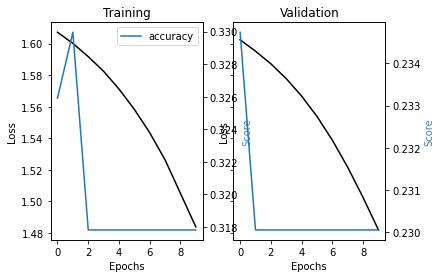

In [18]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()


In [19]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

In [25]:
# predicted

In [22]:
from sklearn import metrics 

accuracy = metrics.accuracy_score(list(y_test), list(predicted))
# auc = metrics.roc_auc_score(y_test_array, predicted_prob, multi_class="ovr")
# y_test_array = pd.get_dummies(y_test, drop_first=False).values
print("Accuracy:",  round(accuracy,2))
# print("Auc:", round(auc,2))
print("Detail:")
# print(metrics.classification_report(y_test, predicted))

Accuracy: 0.0
Detail:
